# Exploring correlations in chemical data

This session will build on the ideas developed in session 09, and give you the chance to explore correlations that may (or may not) exist between chemical composition, analytical data and observed properties. The session will introduce a few techniques which are helpful when processing chemical data, but is mainly intended for you to apply what you have learnt from DDC, and to get help or advice on using Python for chemistry.

The point of this session is to understand that the physical properties of a molecule are a result of its atomic structure - if we can develop tools to understand this link we might be able to design molecules to solve specific problems (*e.g.* drug targets). This idea underpins [chemoinformatics](https://doi.org/10.1021/ci600234z), and the same idea is behind the wider application of machine learning to scientific discovery.


## Learning Outcomes

By the end of this session, you should have improved your skills in:

- Writing reusable code
- Using tools to manipulate and process text (string) data
- Plotting data as a way to examine correlations
- Combining data from multiple sources


# Data sources

In session 09 you were given NMR spectra for a set of molecules, and a summary of how many heteroatoms they had. For the same set of molecules, `data_sources/molecule_summary.csv` contains more information about each molecule:
- **index** - the ID of each molecule (consistent with the NMR labels)
- **Formula**
- **Name** - common name
- **IUPAC** - official name using IUPAC rules
- **csid** - The unique identifier of the molecule on the RSC's [ChemSpider](https://www.chemspider.com/) database
- **h-bond acceptors** / **h-bond donors**
- **pka** - extracted from ChemSpider (where known)

You will also find a copy of the "Jean-Claude Bradley Open Melting Point Database" (`data_sources/BradleyMeltingPointDataset.xlsx`). This dataset is [freely available](http://dx.doi.org/10.6084/m9.figshare.1031637) and contains the results of over 28,000 melting point measurements.

You can, of course, also use the original NMR data from last session (accessible using `../Session_09_application2/data_sources/NMR_data/...` file paths)

# Task 1

The first step is to combine all the data we might want to analyse, and perform any initial processing. Specifically, we need to:

1. Load the `molecule_summary.csv` file
2. Combine the number of NMR peaks for each molecule with the summary data
3. Extract the relevant melting points from the Bradley database, and store them with our summary
4. Calculate the molecular mass for each molecule

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Task 1.1 - Load summary


In [2]:
summary = pd.read_csv('data_sources/molecule_summary.csv', sep=';')
summary.set_index('index', inplace=True)
summary.head()


Formula                     Name  \
index                                    
1      C10H16             Alpha pinene   
2      C6H8N2         Phenyl hydrazine   
3      C9H10O  2-phenylpropionaldehyde   
4       C9H7N             isoquinoline   
5      C5H8O2      isopropenyl acetate   

                                         IUPAC    csid  h-bond donors  \
index                                                                   
1      2,6,6-trimethylbicyclo[3.1.1]hept-2-ene  6402.0              0   
2                              phenylhydrazine  7235.0              2   
3                             2-phenylpropanal  6879.0              0   
4                                 isoquinoline  8098.0              0   
5                       prop-1-en-2-yl acetate  7628.0              0   

       h-bond acceptors    pka  
index                           
1                     0    NaN  
2                     2   5.14  
3                     1  14.77  
4                     1   5.26  
5                     2    NaN

## Task 1.2 - Count NMR peaks

- As a rule, it is a *very* bad idea to duplicate code
    - If you change it in one place, you need to do that for all copies
- If you find yourself reusing code, it's better to turn it into a "module" and `import` it.

<div class="alert alert-warning">
    <em>Note</em>: once imported, Jupyter will not notice any changes to the module. If you edit the .py file, you will need to restart the Jupyter kernel and run import again!
</div>



In [3]:
import NMR_counting


In [4]:
NMR_directory = '../Session_09_application2/data_sources/NMR_data/'

NMR_data = {}

for ID in summary.index:
    file = NMR_directory + str(ID) + '.txt'
    NMR_data[ID] = NMR_counting.read_NMR_data(file)
    
    num_peaks = NMR_counting.count_peaks(NMR_data, ID=ID, prominence=1)
    
    summary.loc[ID, 'NMR_peaks'] = num_peaks
    


## Task 1.3 - Extract melting points


In [5]:
all_melting_points = pd.read_excel('data_sources/BradleyMeltingPointDataset.xlsx')
all_melting_points.set_index('key', inplace=True)
all_melting_points.head()


name  \
key                                  
1    2-(2,4-dinitrobenzyl)pyridine   
2         2-(1-piperidinyl)aniline   
3      2-(1-piperazinyl)pyrimidine   
4          2-(1-piperazinyl)phenol   
5     2-(1-cyclohexenyl)ethylamine   

                                            smiles    mpC    csid  \
key                                                                 
1    c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-]   92.0   64018   
2                            c1ccc(c(c1)N)N2CCCCC2   46.0  403764   
3                               c1cnc(nc1)N2CCNCC2   33.0   80080   
4                            c1ccc(c(c1)N2CCNCC2)O  125.0   63701   
5                                   C1CCC(=CC1)CCN  -55.0   69388   

                                               link      source donotuse  \
key                                                                        
1    http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192  Alfa Aesar      NaN   
2    http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073  Alfa Aesar      NaN   
3    http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884  Alfa Aesar      NaN   
4    http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252  Alfa Aesar      NaN   
5    http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261  Alfa Aesar      NaN   

    donotusebecause  
key                  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
5               NaN

In [6]:
def extract_mean_melting_point(csid):
    """ Return the mean melting point for a molecule based on its ChemSpider ID. """
    
    all_records = all_melting_points[all_melting_points['csid'] == csid]
    
    return all_records['mpC'].mean()


In [7]:
summary['mpC'] = summary['csid'].apply(extract_mean_melting_point)

summary.head()


Formula                     Name  \
index                                    
1      C10H16             Alpha pinene   
2      C6H8N2         Phenyl hydrazine   
3      C9H10O  2-phenylpropionaldehyde   
4       C9H7N             isoquinoline   
5      C5H8O2      isopropenyl acetate   

                                         IUPAC    csid  h-bond donors  \
index                                                                   
1      2,6,6-trimethylbicyclo[3.1.1]hept-2-ene  6402.0              0   
2                              phenylhydrazine  7235.0              2   
3                             2-phenylpropanal  6879.0              0   
4                                 isoquinoline  8098.0              0   
5                       prop-1-en-2-yl acetate  7628.0              0   

       h-bond acceptors    pka  NMR_peaks        mpC  
index                                                 
1                     0    NaN       36.0 -59.583333  
2                     2   5.14       18.0  19.300000  
3                     1  14.77       44.0        NaN  
4                     1   5.26       20.0  26.235000  
5                     2    NaN       21.0 -92.950000

## Task 1.4 - Calculate molecular mass

To do this, we need to convert the molecular formula (as a string) into a dict of {atom type: number}.

See [Regular expressions notebook](./regular_expressions.ipynb) for details of processing the text.


In [8]:
def composition_from_formula(formula):
    """ Return a dictionary of composition based on a formula string. """
    
    import re
    
    # Extract elements (always uppercase letter, optionally followed by a lowercase letter)
    # and 0 or more digits afterwards
    element_list = re.findall('([A-Z][a-z]?)(\d*)', formula)
    
    composition = {}
    
    for group in element_list:
        if group[1] == '':
            composition[group[0]] = 1
        else:
            composition[group[0]] = int(group[1])
            
    return composition
    


In [9]:
summary['composition'] = summary['Formula'].apply(composition_from_formula)

summary.head()


Formula                     Name  \
index                                    
1      C10H16             Alpha pinene   
2      C6H8N2         Phenyl hydrazine   
3      C9H10O  2-phenylpropionaldehyde   
4       C9H7N             isoquinoline   
5      C5H8O2      isopropenyl acetate   

                                         IUPAC    csid  h-bond donors  \
index                                                                   
1      2,6,6-trimethylbicyclo[3.1.1]hept-2-ene  6402.0              0   
2                              phenylhydrazine  7235.0              2   
3                             2-phenylpropanal  6879.0              0   
4                                 isoquinoline  8098.0              0   
5                       prop-1-en-2-yl acetate  7628.0              0   

       h-bond acceptors    pka  NMR_peaks        mpC  \
index                                                  
1                     0    NaN       36.0 -59.583333   
2                     2   5.14       18.0  19.300000   
3                     1  14.77       44.0        NaN   
4                     1   5.26       20.0  26.235000   
5                     2    NaN       21.0 -92.950000   

                     composition  
index                             
1             {'C': 10, 'H': 16}  
2       {'C': 6, 'H': 8, 'N': 2}  
3      {'C': 9, 'H': 10, 'O': 1}  
4       {'C': 9, 'H': 7, 'N': 1}  
5       {'C': 5, 'H': 8, 'O': 2}

Now we have the composition, we can compute the molecular mass.


In [10]:
import mendeleev


In [11]:
def mass_from_composition(composition):
    """ Generate a molecular mass based on a composition dictionary. """
    
    molecular_mass = 0
    for element in composition:
        molecular_mass += composition[element] * mendeleev.element(element).mass
        
    return molecular_mass


In [12]:
summary['molecular_mass'] = summary['composition'].apply(mass_from_composition)

summary.head()


Formula                     Name  \
index                                    
1      C10H16             Alpha pinene   
2      C6H8N2         Phenyl hydrazine   
3      C9H10O  2-phenylpropionaldehyde   
4       C9H7N             isoquinoline   
5      C5H8O2      isopropenyl acetate   

                                         IUPAC    csid  h-bond donors  \
index                                                                   
1      2,6,6-trimethylbicyclo[3.1.1]hept-2-ene  6402.0              0   
2                              phenylhydrazine  7235.0              2   
3                             2-phenylpropanal  6879.0              0   
4                                 isoquinoline  8098.0              0   
5                       prop-1-en-2-yl acetate  7628.0              0   

       h-bond acceptors    pka  NMR_peaks        mpC  \
index                                                  
1                     0    NaN       36.0 -59.583333   
2                     2   5.14       18.0  19.300000   
3                     1  14.77       44.0        NaN   
4                     1   5.26       20.0  26.235000   
5                     2    NaN       21.0 -92.950000   

                     composition  molecular_mass  
index                                             
1             {'C': 10, 'H': 16}         136.238  
2       {'C': 6, 'H': 8, 'N': 2}         108.144  
3      {'C': 9, 'H': 10, 'O': 1}         134.178  
4       {'C': 9, 'H': 7, 'N': 1}         129.162  
5       {'C': 5, 'H': 8, 'O': 2}         100.117

# Task 2

Now we have collated the data, it is time to explore any correlations that are present. You can choose which parameters you wish to investigate depending on what you think is chemically useful, but some suggestions are:

- How does the number of H-bond donors or acceptors affect melting point?
- Does melting point correlate with molecular weight?
- Do different functional groups give rise to different pKa distributions?
    > Hint: You can extract some knowledge about functional groups based on the IUPAC name
- Is pKa influenced by the presence of H-bond donors/acceptors?

## Example - melting points and molecular mass

We will look at if there is a correlation between melting point and molecular mass. The methods we use here could equally be applied to other columns of data, or other data sets entirely.


Text(0, 0.5, 'Melting Point ($^{\\circ} C$)')

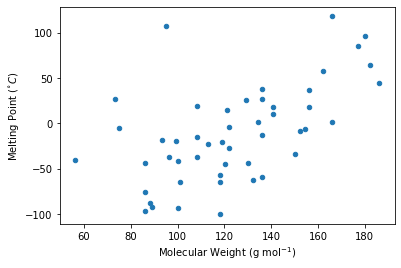

In [70]:
fig = plt.figure()
ax = fig.add_subplot()
summary.plot(kind='scatter', x='molecular_mass', y='mpC', ax=ax)
ax.set_xlabel('Molecular Weight (g mol$^{-1}$)')
ax.set_ylabel('Melting Point ($^{\circ} C$)')


### Explanation

Broadly speaking, there is a positive correlation between molecular mass and melting point (we could compute a Pearson's R-coefficient to quantify this given more time).

This agrees with what we might expect - as molecules get larger, they tend to become less volatile (e.g. hydrocarbons). However, we also know that other things influence melting points, such as the presence of H-bonds. Let's try plotting the same correlation, but separating data points by their H-bonding character.


## Pandas `groupby`

The number of hydrogen bond donors/acceptors in a molecule can take a limited number of (integer) values - it is like a categorical variable. We could write a function that would extract different rows of `summary` based on this value, but Pandas gives us a convenient way to do this - `df.groupby(by='column_name)`. This creates separate groups based on all the unique values in (one or more) columns, which you can then use for further processing.

You can do many useful things with `groupby`, but here we just want to take each of the groups in turn (using a loop) and plot them on the same axes.


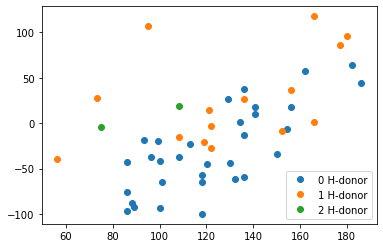

In [72]:
fig = plt.figure()
ax = fig.add_subplot()
all_groups = summary.groupby(['h-bond donors'])

# Iterating over a `groupby` object returns two values each time;
# the group value and also a DataFrame containing just the relevant rows.
for key, group in all_groups:
    ax.plot(group['molecular_mass'], group['mpC'], label=f"{key} H-donor", marker='o', linestyle='')
    
ax.legend()


## Explanation

From this plot, it would appear that as the number of H-bond donors increases, so too does the melting point (for the same molecular weight). The data are quite sparse, though, so stronger conclusions could be drawn with more points in the dataset.
